In [76]:
from math import log, exp, sqrt, sin, cos, pi
import numpy
from numpy import split, array, arctan, mean, zeros, sin, cos, pi, arange, concatenate

import pandas as pd

from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.linear_model import LinearRegression

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import tensorflow
from tensorflow.keras import backend as K
from tensorflow.keras.losses import MeanSquaredLogarithmicError
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, LSTM
from tensorflow.python.keras.layers import RepeatVector, TimeDistributed, Bidirectional, Dropout

import matplotlib
from matplotlib import pyplot

pyplot.style.use('ggplot')

from IPython.display import Image 
import datetime, os

# Load the TensorBoard notebook extension
#%load_ext tensorboard
pyplot.rcParams['figure.dpi'] = 100
pyplot.rcParams['figure.figsize'] = [12,5]
matplotlib.rc('lines', linewidth=1, linestyle='-')

print("Num GPUs Available: ", len(tensorflow.config.list_physical_devices('GPU')))
print(tensorflow.test.gpu_device_name())
physical_devices = tensorflow.config.list_physical_devices('GPU')
tensorflow.config.experimental.set_memory_growth(physical_devices[0], enable=True)

Num GPUs Available:  1
/device:GPU:0


In [77]:
#%reload_ext tensorboard

In [78]:
# MAAPE metric -> does not have the same behaviour as MAPE for actual values close to zero, which is good

def mean_arctangent_absolute_percentage_error(actual, predicted):

    return mean(arctan(abs((actual - predicted) / actual))) * 100

In [79]:
def computeHCF(x, y):
    if x > y:
        smaller = y
    else:
        smaller = x
    for i in range(1, smaller+1):
        if((x % i == 0) and (y % i == 0)):
            hcf = i
    return hcf

In [80]:
# train the model
def build_model(train, n_input, n_output, stride=1, units=64, epochs=50, test_size=0):
    # prepare data
    train_x, train_y = to_supervised(train, n_input, n_output, stride)
    # Model variables
    verbose = 1  # batch_size 1 IS SGD, 1<BATCH_SIZE<SIZE IS MINIBATCH GD AND BATCH_SIZE=SIZE IS BATCH GD
    n_timesteps, n_features = train_x.shape[1], train_x.shape[2]
    # final data preparation for the model
    # reshape train_output into [samples, timesteps, features] for the LSTMs
    train_y = train_y.reshape(train_y.shape[0], train_y.shape[1], 1)
    batch_size = computeHCF(train_x.shape[0], test_size)
    # define model
    model = Sequential()

    # VANILLA LSTM
    model.add(LSTM(units, batch_input_shape=(batch_size, train_x.shape[1], train_x.shape[2]), stateful=True))
    model.add((Dense(n_output)))

    model.compile(loss="mse", optimizer='adam',
                  metrics=["mae"])  # Reminder: LOSS function is MSE but others can be used!

    early = tensorflow.keras.callbacks.EarlyStopping('loss', patience=10)

    # fit network
    for i in range(epochs):
        model.fit(train_x, train_y, epochs=1, batch_size=batch_size, verbose=verbose, callbacks=[early], shuffle=False)
        model.reset_states()

    print(model.summary())

    new_batch = 1
    # re-define model
    new_model = Sequential()
    new_model.add(LSTM(units, batch_input_shape=(new_batch, train_x.shape[1], train_x.shape[2]), stateful=True))
    new_model.add(Dense(n_output))
    # copy weights
    old_weights = model.get_weights()
    new_model.set_weights(old_weights)

    return new_model

In [81]:
def test_stationarity(timeseries):
    # Determing rolling statistics
    rolmean = pd.Series(timeseries).rolling(window=12).mean()
    rolstd = pd.Series(timeseries).rolling(window=12).std()

    # Plot rolling statistics:
    orig = pyplot.plot(timeseries, color='blue', label='Original')
    mean = pyplot.plot(rolmean, color='red', label='Rolling Mean')
    std = pyplot.plot(rolstd, color='black', label='Rolling Std')
    pyplot.legend(loc='best')
    pyplot.title('Rolling Mean & Standard Deviation')
    pyplot.show(block=False) 

    # Perform the augmented Dickey-Fuller test:
    print('Results of Dickey-Fuller Test:')
    dftest = adfuller(timeseries, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)' % key] = value
    print(dfoutput)

In [82]:
# load the csv file
# ../old_data//30min/30minstore290.csv
# ../old_data/30min/30minstore1027.csv
# ../30min/30minstore274.csv
# special case01: ../old_data/30min/partial_covid_stationary_sliced_30minstore274.csv
# special case02: ../old_data/30min/full_covid_nonstationary_sliced_30minstore274.csv
# predict covid:  ../old_data/30min/predict_covid_30minstore274


# NEW STORES
# ../Treatment/imputed_stores/linear_interp_store0057.csv
# ../Treatment/new_stores/store_0057.csv

# ../Treatment/imputed_stores/linear_interp_store4969.csv
# ../Treatment/new_stores/store_4969.csv




# IMPUTED DATASET
dataset = pd.read_csv('../Treatment/imputed_stores/linear_interp_store0011.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])
# NORMAL DATASET
#dataset = pd.read_csv('../Treatment/new_stores/store_0057.csv', header=0, infer_datetime_format=True,parse_dates=['ds'], index_col=['ds'])
print(dataset)

                      sales  n_clients imputed
ds                                            
2015-01-02 09:00:00  313.80       66.0     yes
2015-01-02 09:30:00  313.80       66.0     yes
2015-01-02 10:00:00  313.80       66.0      no
2015-01-02 10:30:00  313.34       54.0      no
2015-01-02 11:00:00  545.89       89.0      no
...                     ...        ...     ...
2020-10-17 19:30:00  212.47       42.0      no
2020-10-17 20:00:00  156.72       39.0      no
2020-10-17 20:30:00  257.43       57.0      no
2020-10-17 21:00:00  116.61       22.0      no
2020-10-17 21:30:00   45.59        3.0      no

[47892 rows x 3 columns]


In [83]:
# PARAMETERS
dataset_day = 26             # nr of samples in a day
n_input = dataset_day                 # steps used to predict (autoregressive order) p
n_output = 1              # steps to predict (forecast horizon) H
test_set = dataset_day*30              # last observations for the test_set
data_split = test_set        # to split the data in windows
stride = n_input                   # stride value for the sliding window method (overlapped vs non-overlapped)
init_train_set = 0           # refers to when the train_set starts, this is useful for the sliding window method
walkforward = False           # walkforward validation 
iterations = 1
encode_weekday = False       # If the string weekday is included in the dataset
imputed = True                # To remove idxs in evaluation from a supposed imputed model
compare_imputed = False        # If the results are to be compared to an imputed version, False if we're not trying to compare


# IMPORTANT WARNING! 
# If n_output is too large and there's not enough train data to split, 
# consider having a one shot large prediction over the test_set (not future) without splitting
# This is used when the train/test ratio is 50(or less)/50 and walkforward is not required!
# This can be used with future_prediction and two predictions are calculated
single_prediction = True
    

# the changes if a large single prediction is conducted
if single_prediction:
    walkforward = False
    data_split = n_output
    
    
print("Train beginning:\n")
print(dataset.iloc[init_train_set])
dataset = dataset.iloc[init_train_set:]
print("\nTrain end:\n")
print(dataset.iloc[-test_set-1])
print("\nTest beggining:\n")
print(dataset.iloc[-test_set])
print("\nTest end:\n")
print(dataset.iloc[-1])

print("\nParameters:    n_input / n_output / stride")
print(n_input, n_output, stride)


if imputed:
    # if imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    imputed_idx = numpy.where(dataset.imputed=="yes")[0].tolist()
elif compare_imputed:
    # if compare_imputed is true this will be used; its to remove hours that cannot be compared with an imputed model
    remove_idx = dataset.between_time('21:01', '08:59')
    remove_idx = numpy.where(dataset.index.isin(remove_idx.index))[0].tolist()


# Univariate
dataset = dataset[['n_clients']]
dataset = dataset.astype('int64')
train_dataset = dataset.iloc[:-test_set]
n_features = len(dataset.columns)
print(dataset, n_features)

Train beginning:

sales        313.8
n_clients       66
imputed        yes
Name: 2015-01-02 09:00:00, dtype: object

Train end:

sales         2
n_clients     2
imputed      no
Name: 2020-09-11 21:30:00, dtype: object

Test beggining:

sales        141.76
n_clients        41
imputed          no
Name: 2020-09-12 09:00:00, dtype: object

Test end:

sales        45.59
n_clients        3
imputed         no
Name: 2020-10-17 21:30:00, dtype: object

Parameters:    n_input / n_output / stride
26 1 26
                     n_clients
ds                            
2015-01-02 09:00:00         66
2015-01-02 09:30:00         66
2015-01-02 10:00:00         66
2015-01-02 10:30:00         54
2015-01-02 11:00:00         89
...                        ...
2020-10-17 19:30:00         42
2020-10-17 20:00:00         39
2020-10-17 20:30:00         57
2020-10-17 21:00:00         22
2020-10-17 21:30:00          3

[47892 rows x 1 columns] 1


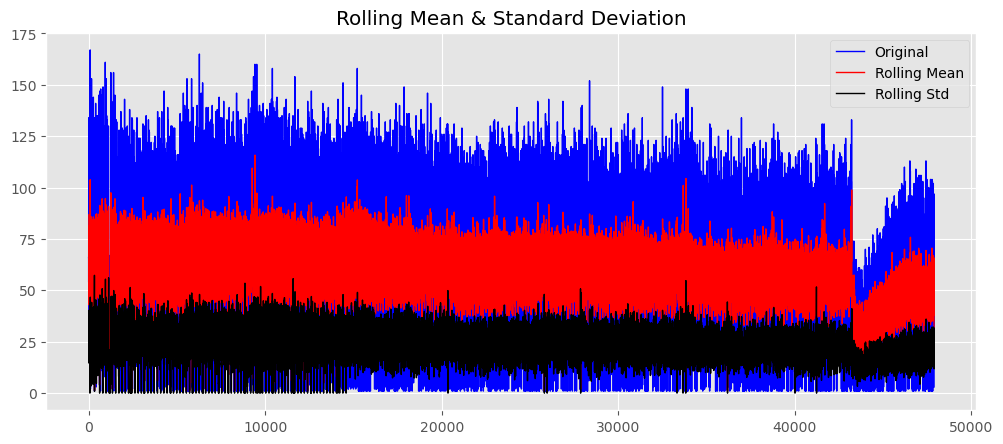

Results of Dickey-Fuller Test:
Test Statistic                   -19.759141
p-value                            0.000000
#Lags Used                        57.000000
Number of Observations Used    47834.000000
Critical Value (1%)               -3.430487
Critical Value (5%)               -2.861600
Critical Value (10%)              -2.566802
dtype: float64


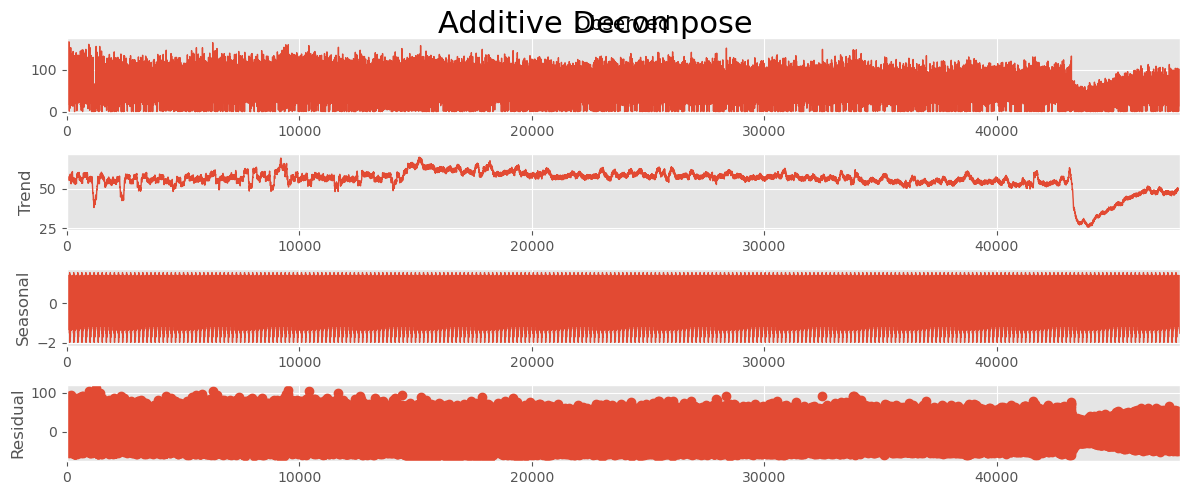

In [84]:
# Check components and stationarity of the forecast variable
forecast_variable = dataset['n_clients'].values

# Test stationarity
test_stationarity(forecast_variable)

# Additive Decomposition
result_add = seasonal_decompose(forecast_variable, model='additive', period=175)

# Plot components

result_add.plot().suptitle('Additive Decompose', fontsize=22)
pyplot.show()

In [85]:
values = dataset.values
# Encode weekday
if encode_weekday:
    encoder = LabelEncoder()
    values[:, 1] = encoder.fit_transform(values[:, 1])

# ensure all data is float
values = values.astype('float32')

print(values.shape)

(47892, 1)


In [86]:
# split into train and test, leave the last test_set blocks for n_output timesteps
train, test = values[:-test_set*iterations], values[-test_set*iterations:]  

# Normalization
scaler = StandardScaler() #MinMaxScaler(feature_range=(0, 1)) 
train = scaler.fit_transform(train)
test = scaler.transform(test)

#for walkforward
def normalize_train(scaler, train):
    train = scaler.fit_transform(train)
    return train

# restructure into windows, for the sliding window method
train = array(split(train, len(train) / data_split))
test = array(split(test, len(test) / test_set))
print(train.shape, test.shape)

(47112, 1, 1) (1, 780, 1)


In [87]:
# convert history into inputs and outputs - framing to a supervised learning problem
def to_supervised(train, n_input, n_output, stride=1):
    # flatten data
    data = train.reshape(train.shape[0] * train.shape[1], train.shape[2])
    train_x, train_y = list(), list()
    in_start = 0
    # step over the entire history one STRIDE step at a time
    for _ in range(0, len(data), stride):
        # define the end of the input sequence
        in_end = in_start + n_input
        out_end = in_end + n_output
        # ensure we have enough data for this instance
        if out_end <= len(data):
            #print("iteration")
            #print(_)
            #print("x")
            #print(in_start,in_end)
            #print("y")
            #print(in_end,out_end)
            train_x.append(data[in_start:in_end, :])
            train_y.append(data[in_end:out_end, 0])
        # move along stride time steps
        in_start += stride
    print(array(train_x).shape, array(train_y).shape)
    return array(train_x), array(train_y)

In [88]:
# make the multi-step forecast
def forecast(model, history, n_input):
    # flatten data
    data = array(history)
    input_x = data.reshape(1, n_input, 1)
    input_x = numpy.asarray(input_x).astype('float32')
    #print(input_x.shape)
    
    # forecast the next n_output steps
    yhat = model.predict(input_x, verbose=0)
    
    # we only want the forecast variable
    yhat = yhat[0]
    return yhat

In [89]:
# invert the scaling
def invTransformTarget(scaler, data):
    dummy = pd.DataFrame(zeros((len(data), scaler.n_features_in_)))
    dummy[0] = data
    dummy = pd.DataFrame(scaler.inverse_transform(dummy), columns=dummy.columns)
    return dummy[0].values

walkforward expanding: 1
total expansions: 1
(47086, 26, 1) (47086, 1)
1811/1811 [==============================] - 5s 3ms/step - loss: 0.2221 - mae: 0.3448
Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_5 (LSTM)                (26, 64)                  16896     
_________________________________________________________________
dense_5 (Dense)              (26, 1)                   65        
Total params: 16,961
Trainable params: 16,961
Non-trainable params: 0
_________________________________________________________________
None
Test unnormalized error to compare to training loss:
1.2370793044005337
47112
The following errors are calculated without the imputed observations!



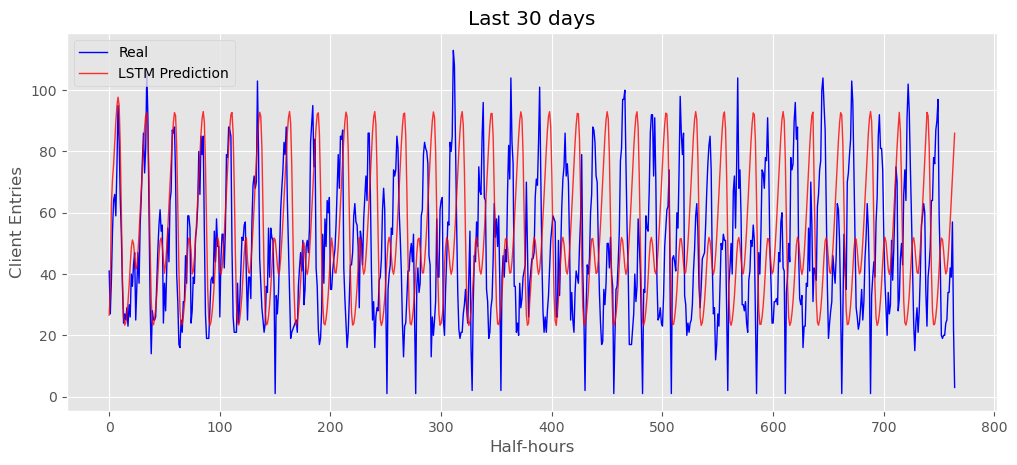

size of target and prediction:
765 765
Each n_output score, iteration 0 
RMSE 31.816321289751993
MAE 25.383886630129425
MAPE 145.77465962789614
MAAPE 48.46585599785207 



'    \nplot_model(model, show_shapes=True, show_layer_names=True, to_file=\'model.png\')\nImage(\'model.png\') \n# The question mark means that first dimension is not fixed in the graph and it can vary between run calls\nprint("The lower visualizations are only useful if walkforward (and multiple predictions) is employed")\n'

In [90]:
# %matplotlib notebook
# history of windows, is updated for each prediction
history = [x for x in train]

# Time Series CROSS-VALIDATION
# we don't need to retrain all the time though!
for i in range(iterations):
    yhat_sequence = list()
    print("walkforward expanding: %s" % (i + 1))
    print("total expansions: %s" % (iterations))
    # the model is trained and retrained for every number of n_output to predict
    model = build_model(array(history), n_input, n_output, stride=1, units=64, epochs=1, test_size=test_set)
    train_size = len(history)  # number of training windows
    len_train = train_size * test_set  # actual training size/length
    if single_prediction:
        len_train = train_size
    # predict the next n_output steps
    for j in range(test_set):
        if j == 0:
            inp = array(history).flatten()[-n_input:]
            yhat = forecast(model, inp, n_input)
        else:
            inp = inp.flatten()[-n_input:]
            yhat = forecast(model, inp, n_input)
        inp = numpy.append(inp, yhat.item(0))
        # print(yhat.shape)
        yhat_sequence = array(yhat_sequence)
        yhat_sequence = numpy.append(yhat_sequence, yhat.item(0))
        # print(yhat_sequence)

    print("Test unnormalized error to compare to training loss:")
    # print(array(test).shape, len(yhat_sequence))
    # print(array(test[:test_set*(i+1)]).shape)
    print(mean_squared_error(array(test[i, :, 0]).flatten(), yhat_sequence))

    # invert the scaling on predictions
    yhat_sequence = invTransformTarget(scaler, yhat_sequence)
    yhat_sequence = yhat_sequence.tolist()

    # invert scaling for real values
    test_y = invTransformTarget(scaler, array(test[i, :, 0]).flatten())

    if walkforward:
        history.append(test[i, :])
        arr_history = array(history)
        n_windows = arr_history.shape[0]
        arr_history = invTransformTarget(scaler, arr_history.flatten())
        arr_history = arr_history.reshape(n_windows * test_set, n_features)
        arr_history = normalize_train(scaler, arr_history)
        history = list(arr_history.reshape(n_windows, test_set, n_features))

    if imputed:
        print(len_train)
        list_idx = []
        for idx in imputed_idx:
            if len_train - 1 < idx < len_train + test_set:
                list_idx.append(idx - len_train)
        if list_idx:
            yhat_sequence = numpy.delete(yhat_sequence, list_idx)
            test_y = numpy.delete(test_y, list_idx)
            print("The following errors are calculated without the imputed observations!\n")

    if compare_imputed:
        list_idx = []
        for idx in remove_idx:
            if len_train - 1 < idx < len_train + test_set:
                list_idx.append(idx - len_train)
        if list_idx:
            yhat_sequence = numpy.delete(yhat_sequence, list_idx)
            test_y = numpy.delete(test_y, list_idx)
            print(
                "The following errors are calculated without observations that do not fit into the wanted schedule!\n")
            print(list_idx)

    # plot each iteration
    # print(yhat_sequence)
    pyplot.title('Last 30 days')
    pyplot.plot(test_y, color="blue", label="Real")
    pyplot.plot(yhat_sequence, alpha=0.8, color="red", label="LSTM Prediction")
    pyplot.legend(loc="upper left")
    pyplot.xlabel("Half-hours")
    pyplot.ylabel("Client Entries")
    pyplot.show()

    print("size of target and prediction:")
    print(len(test_y), len(yhat_sequence))
    # Score only from the each modelled n_output
    rmse = sqrt(mean_squared_error(test_y, yhat_sequence))
    mae = mean(abs(test_y - yhat_sequence))
    mape = mean(abs(test_y - yhat_sequence) / test_y) * 100
    maape = mean_arctangent_absolute_percentage_error(test_y, yhat_sequence)
    print('Each n_output score, iteration %s \nRMSE %s' % (0, rmse))
    print('MAE %s' % (mae))
    print('MAPE %s' % (mape))
    print('MAAPE %s \n' % (maape))
"""    
plot_model(model, show_shapes=True, show_layer_names=True, to_file='model.png')
Image('model.png') 
# The question mark means that first dimension is not fixed in the graph and it can vary between run calls
print("The lower visualizations are only useful if walkforward (and multiple predictions) is employed")
"""